In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
#import geopandas
from shapely.geometry import Point


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
station_data_orig = pd.read_csv("/content/drive/My Drive/Data/Bikes_data/data/station_data.csv")
trip_data_orig = pd.read_csv('/content/drive/My Drive/Data/Bikes_data/data/trip_data.csv')
weather_data_orig = pd.read_csv('/content/drive/My Drive/Data/Bikes_data/data/weather_data.csv')

Copying datasets to another dataframe

In [0]:
station_data_dup = station_data_orig.copy()
weather_data_dup = weather_data_orig.copy()
trip_data_dup = trip_data_orig.copy()

Understanding  the **station** data by seeing the dataset head

Understanding the **Weather** data by seeing the dataset head

In [5]:
weather_data_dup.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,29.87,29.82,29.79,10.0,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,29.81,29.76,29.72,10.0,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,29.81,29.76,29.72,10.0,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,29.92,29.87,29.81,10.0,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


Understanding the **Tripdata** data by seeing the dataset head

In [6]:
trip_data_dup.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


#Assigning the station_id that is of interest

In [0]:
# Assigining the constants
station_id = 47

##Defining functions to explore and modify dataset

###The idea is to write a function such that the ETL approach would be standard to this type of data. 

The function preprocess_features_station is created for selecting columns and renaming specified changes station names as metnioned in the task. It takes input as station dataframe. 

In [0]:
def preprocess_features_station(df):
    '''Prepares input features
    and for now it also drops "Name" column
    and changes the "moved station id" as mentioned in the problem'''
       
    selected_features = df [[ "Id", 
                                          "Dock Count",
                                          "City"]]
    
    processed_features_station = selected_features.copy()
    #From the question it says some of the following stations are moved to the new numbers
    number_mapping = { 23: 85 , 25 : 86, 49 : 87, 69 : 88, 72 : 90}

    processed_features_station['Id']= processed_features_station ['Id'].replace(number_mapping)
    print ("shape of the station dataframe is :",processed_features_station.shape )
    
    return processed_features_station

###Processing function for weather dataset
The data processing of weather contains  some null values and etc were we filter it


In [0]:
def preprocess_features_weather(df):
   
       
    selected_features = df 
    
    processed_features_weather = selected_features.copy()
    #Lets check for NaN values
    total = weather_data_dup.isnull().sum().sort_values(ascending = False)
    percentage = (weather_data_dup.isnull().sum()/weather_data_dup.isnull().count()).sort_values(ascending = False) *100
    missing_data = pd.concat ([total,percentage], axis = 1, keys =  ['total', 'percentage'])
    #print (missing_data)
    #For the events column the total percentage of "NaN" is too high so lets drop that column
    processed_features_weather.drop ('Events', axis = 1, inplace = True)
    print ("shape of the weather dataframe is :",processed_features_weather.shape )
    return processed_features_weather

###Processing function for trip data set


In [0]:
def preprocess_features_trip(df):
    
    selected_features = df 
    
    processed_features_trip = selected_features.copy()
    #The "Trip ID" column in this dataframe is just a sequentially generated random number, which won't be having impact on the prediction, for that reason it is dropped.
    processed_features_trip.drop ('Trip ID', axis = 1, inplace = True)
    #Replacing categorical values in column 'Subscriber Type' with 0 and 1
    trip_data_dup['Subscriber Type'] = trip_data_dup['Subscriber Type'].replace('Subscriber', 1)
    trip_data_dup['Subscriber Type'] = trip_data_dup['Subscriber Type'].replace('Customer', 0)
    #Analysis of the data
    #Calculating each trip duration and converting data into seconds
    print ("shape of the trip dataframe is :",processed_features_trip.shape )
    return processed_features_trip

#Analysis of the data


####Analysis of the station data

Text(0.5, 1.0, 'Number of Dock Counts each city')

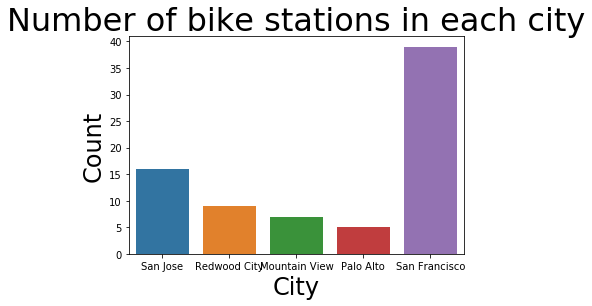

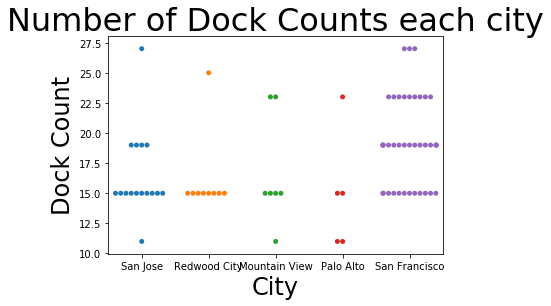

In [11]:
plt.figure()
sns.countplot (x = "City", data = station_data_dup)
plt.xlabel("City", fontsize = 24)
plt.ylabel ("Count", fontsize = 24)
plt.title ("Number of bike stations in each city", fontsize = 32)
plt.figure()
sns.swarmplot (x = "City", y = "Dock Count", data = station_data_dup)
plt.xlabel("City", fontsize = 24)
plt.ylabel ("Dock Count", fontsize = 24)
plt.title ("Number of Dock Counts each city", fontsize = 32)

###Calculating each trip duration and converting data into seconds

Text(0.5, 1.0, 'Trip Duration')

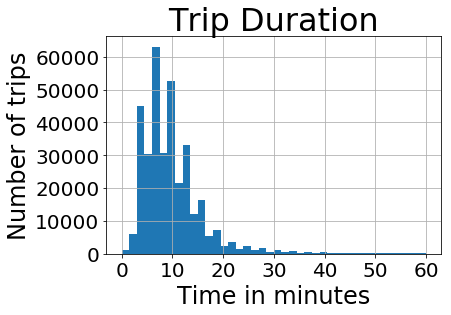

In [12]:
# For knowing the trip duration we have to subtract the time between "Start Station" and "End Station". For doing that we should first convert those column into pandas datetime format
trip_data_dup[['Start Date', 'End Date']] = trip_data_dup[['Start Date', 'End Date']].apply(pd.to_datetime, errors= 'coerce')
#Add trip duration intervals

trip_data_dup['time'] = trip_data_dup['End Date']-trip_data_dup['Start Date']
# convert from timedelta type to seconds
trip_data_dup['time_seconds'] = pd.Series(trip_data_dup['time'], dtype='int64').abs() / (1000*1000*1000)

#PLOTTING THE TRI DURATION#

(trip_data_dup['time_seconds']/60).hist(bins=40, range=(0, 60), xlabelsize=20, ylabelsize=20) # converting the data from seconds to minutes
plt.xlabel('Time in minutes', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Duration', fontsize=32)

In [13]:
trip_data_dup.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,time,time_seconds
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber,00:13:00,780.0
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber,00:17:00,1020.0
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber,00:05:00,300.0
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber,00:07:00,420.0
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer,00:13:00,780.0


Checking the minimum and maximum trip durations

In [14]:
### Do people return to same station often?
self_return = trip_data_dup[trip_data_dup['Start Station'].eq(trip_data_dup['End Station'])]
print("%d %% of the trips go back to same stations" % (len(self_return)/len(trip_data_dup)*100,))

#trip_data_dup['time_seconds'].min()

2 % of the trips go back to same stations


Checking the errors in trip data by looking for the trips which are ending at same station under 2 minutes time. These may occur due to possibility of errors

In [15]:
minimum_duration = 2*60
own_trips = trip_data_dup[trip_data_dup['Start Station'] == (trip_data_dup['End Station'])]
veryshort = own_trips[own_trips['time_seconds'] < minimum_duration]
# invalid = trip_data_dup[own_trips['Duration Seconds'] < minimum_duration] 
print ('Length of very hsort :',len(veryshort))
print ('lenght of big:', len(trip_data_dup))

Length of very hsort : 433
lenght of big: 354152


Plotting the trip duration

In [16]:
valid_trips = trip_data_dup['time_seconds']>minimum_duration
valid_trip_data_dup = trip_data_dup[valid_trips]
len(valid_trip_data_dup)

# Lets see the peak hours
valid_trip_data_dup_hour = valid_trip_data_dup.copy()
valid_trip_data_dup_hour['weekday'] = valid_trip_data_dup_hour['Start Date'].dt.weekday_name
valid_trip_data_dup_hour['hour'] = valid_trip_data_dup_hour['Start Date'].dt.hour
valid_trip_data_dup_hour['weekday'].value_counts()

Tuesday      63252
Friday       57652
Wednesday    57562
Monday       54346
Thursday     53582
Sunday       33318
Saturday     27408
Name: weekday, dtype: int64

Differentiating the Weekday and Weekend rides 

Text(0.5, 1.0, 'Rides per hour during Workday')

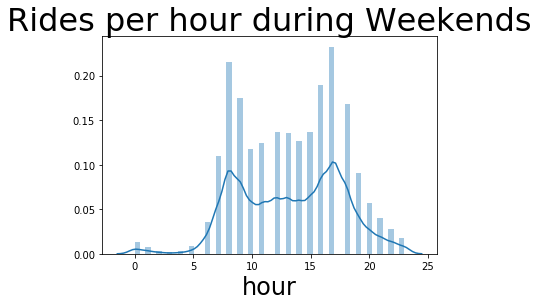

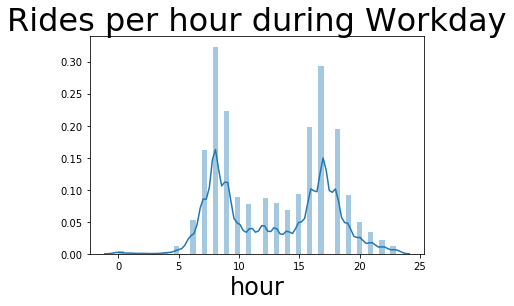

In [17]:
valid_trip_data_dup_hour_weekend =  pd.DataFrame (valid_trip_data_dup_hour[(valid_trip_data_dup_hour['weekday'] == 'Saturday') | (valid_trip_data_dup_hour['weekday'] == 'Sunday')])
valid_trip_data_dup_hour_workday = pd.DataFrame (valid_trip_data_dup_hour[(valid_trip_data_dup_hour['weekday'] != 'Saturday') & (valid_trip_data_dup_hour['weekday'] != 'Sunday')])

len(valid_trip_data_dup_hour_weekend)
plt.figure()
sns.distplot (valid_trip_data_dup_hour_weekend['hour'])
plt.xlabel ("hour", fontsize = 24)
plt.title ("Rides per hour during Weekends", fontsize = 32)
plt.figure()
sns.distplot (valid_trip_data_dup_hour_workday['hour'])
plt.xlabel ("hour", fontsize = 24)
plt.title ("Rides per hour during Workday", fontsize = 32)

#Joining the dataframes

First merging Station and weather dataframes

For doing so there needs to be a common column between two dataframes. That condition is satisfied by mapping column "Zip" in weather dataframe to "City" . Thus there is a common column between two dataframes and merging is perfromed on the same

###Merging of station and weather dataset

1.   List item
2.   List item



In [0]:
def merge_weather_station (station, weather):
  weather.loc [weather['Zip'] == 94063, 'Zip'] = weather['Zip'].replace (94063 , 'Redwood City')    #Redwood_city_weather['Zip'].replace (94063, 'Redwood City')
  weather.loc [weather['Zip'] == 94107, 'Zip'] = weather['Zip'].replace (94107 , 'San Francisco')# Mountain_view_weather['Zip'] =  Mountain_view_weather['Zip'].replace (94041, 'Mountain View')
  weather.loc [weather['Zip'] == 94041, 'Zip'] = weather['Zip'].replace (94041 , 'Mountain View')# San_Jose_weather['Zip'] =  San_Jose_weather['Zip'].replace (95113, 'San Jose')
  weather.loc [weather['Zip'] == 95113, 'Zip'] = weather['Zip'].replace (95113 , 'San Jose')# Palo_Alto_weather['Zip'] =  Palo_Alto_weather['Zip'].replace (94301, 'Palo Alto')
  weather.loc [weather['Zip'] == 94301, 'Zip'] = weather['Zip'].replace (94301 , 'Palo Alto')
  weather.rename (columns = { "Zip" : "City"} , inplace = True) # Renaming the "zip" column as "City" for merging dataframes 
  weather_station = weather.merge(station) # Merging two dataframes
  print (weather_station.shape)
  return weather_station

In [19]:
station = preprocess_features_station (station_data_dup)
weather = preprocess_features_weather(weather_data_dup)
trip = preprocess_features_trip(trip_data_dup)
weather_station_dup = merge_weather_station(station, weather)

shape of the station dataframe is : (76, 3)
shape of the weather dataframe is : (1825, 23)
shape of the trip dataframe is : (354152, 7)
(27740, 25)


In [0]:
# Saving the weather_station_dup for pickle
pickle_out = open("/content/drive/My Drive/Data/Bikes_data/data/weather_station_dup.pickle", "wb")
pickle.dump (weather_station_dup, pickle_out)
pickle_out.close()

###Trip dataset manipulation, because we have to get the net change in bikes at the desired station

In [0]:
def number_of_bikes_station_id (station_id):
        trip_data_dup_index = trip_data_orig.copy() # copying the dataframe
        trip_data_dup_index['Start Date'] = pd.to_datetime (trip_data_dup_index['Start Date'])
        trip_data_dup_index['End Date'] = pd.to_datetime (trip_data_dup_index['End Date'])
        #trip_data_dup_index.drop ('Trip ID', axis = 1, inplace = True) # droping the column \"TripId\" because it doesnt give much information
        trip_data_dup_index.set_index ('Start Date', inplace = True) # setting the index as \"Start date\" for the column\n",
        start_station = trip_data_dup_index[trip_data_dup_index["Start Station"]==station_id].resample('1H').count()
        #"#start_station.reset_index (inplace = True)\n",
        #print (start_station['Start Station'].head(10))\n",
        end_station = trip_data_dup_index[trip_data_dup_index["End Station"]==station_id].resample('1H').count()
        #end_station.reset_index (inplace = True)\n",
        #print(end_station['End Station'].head(10))\n",
        balance_station = pd.concat ([start_station['Start Station'],end_station['End Station']] , axis =1)
        print (balance_station)
        balance_station.fillna(value = 0, inplace = True)
        #balance_station.head(10)\n",
        balance_station['net_change_bikes']= balance_station['End Station']-balance_station['Start Station']
        balance_station['total_bikes_change'] = balance_station['net_change_bikes'].cumsum()
        balance_station['total_bikes_pct_change'] = balance_station['total_bikes_change'].pct_change()
        balance_station.replace ([np.inf, -np.inf], np.nan , inplace = True)
        
        #Dock_count = station_data[station_data['Id'] == station_id]['Dock Count']
        #    Dock_count = Dock_count.values\n",
        #     docks = no_of_bikes+Dock_count\n",
        #     print (docks.min(), docks.max())\n",
        return balance_station

##Merging of weather_station with trip dataset

In [0]:
def trip_weather_station_merge_ID(station_id):
  trip_start_end_station = number_of_bikes_station_id (station_id)
  trip_start_end_station.reset_index(inplace = True) #Remove the index from this
  trip_start_end_station["Date"] = trip_start_end_station["Start Date"].dt.date # creating a new column of Date
  trip_start_end_station.head()
  trip_start_end_station['Date']= pd.to_datetime (trip_start_end_station['Date']) # Converting that column of Date into pandas date format 
  weather_station = pickle.load (open("/content/drive/My Drive/Data/Bikes_data/data/weather_station_dup.pickle", "rb")) # Loading the data of weather_station merger dataframe with pickle
  weather_station['Date']= pd.to_datetime(weather_station['Date'])  # Changing the weather dataframe "Date" column into datetime so that we can merge with start_end_station
  weather_station_id = weather_station[weather_station["Id"] == station_id] # Taking only the values of selected station id
  #weather_station_id = weather_station.copy()
  weather_station_id.fillna(method = 'ffill', inplace = True)
  print ("Weather_station_id shape is" , weather_station_id.shape)
  print ("start_end_station shape is" , trip_start_end_station.shape)
  trip_start_end_station.reset_index( inplace = True)
  weather_station_id.reset_index ( inplace = True)
  trip_weather_station_ID =pd.merge (trip_start_end_station, weather_station_id, on = "Date", how = 'outer')
  print ("The number of rows of the merger should be same as start_end_station length of rows :" ,trip_weather_station_ID.shape)
  trip_weather_station_ID.fillna(method = 'ffill', inplace = True)
  return trip_weather_station_ID
  

In [0]:
trip_weather_station_merge = trip_weather_station_merge_ID(station_id)

##Clustering the stations connectivity

Clustering technique can be applied to get the connectivity between the stations

In [27]:
outbound = pd.crosstab (trip_data_dup['Start Station'], trip_data_dup['End Station'])
inbound = pd.crosstab (trip_data_dup['End Station'], trip_data_dup['Start Station'])
connectivity = inbound + outbound
connectivity.index
#connectivity[connectivity['Start Station']==2]

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
            24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41,
            42, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62,
            63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82,
            83, 84, 85, 86, 87, 88, 89, 90],
           dtype='int64', name='End Station')

In [0]:
# Save the data to pickle
pickle_out = open ("/content/drive/My Drive/Data/Bikes_data/data/trip_weather_station_merge.pickle", "wb")
pickle.dump (trip_weather_station_merge, pickle_out)
pickle_out.close()

